# Incidenze

Incidenze regionali su 100'000 abitanti.

> Max Pierini

In [1]:
import numpy as np
import pandas as pd
#from benfordslaw import benfordslaw
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import Markdown
import seaborn as sns

import scipy.stats as sps

sns.set()

In [2]:
istat_to_dpc = {
    "Abruzzo":     'Abruzzo',
    "Basilicata":     'Basilicata',
    "Calabria":     'Calabria',
    "Campania":     'Campania',
    "Emilia-Romagna":     'Emilia-Romagna',
    "Friuli-Venezia Giulia":     'Friuli Venezia Giulia',
    "Lazio":     'Lazio',
    "Liguria":     'Liguria',
    "Lombardia":     'Lombardia',
    "Marche":     'Marche',
    "Molise":     'Molise',
    "Provincia Autonoma Bolzano / Bozen":     'P.A. Bolzano',
    "Provincia Autonoma Trento":     'P.A. Trento',
    "Piemonte":     'Piemonte',
    "Puglia":     'Puglia',
    "Sardegna":     'Sardegna',
    "Sicilia":     'Sicilia',
    "Toscana":     'Toscana',
    "Umbria":     'Umbria',
    "Valle d'Aosta / Vallée d'Aoste":     "Valle d'Aosta",
    "Veneto":     'Veneto',
}

In [3]:
pop = pd.read_csv('ISTAT_popolazione.csv')

In [4]:
pop_reg = pop[
    (pop.Sesso=='totale') & (pop.Età=='totale') & (pop.Territorio!='Trentino Alto Adige / Südtirol')
].reset_index()[['Territorio', 'Value']]

In [5]:
pop_reg["Territorio"] = pop_reg.Territorio.map(istat_to_dpc)

In [6]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [7]:
it = covid_regioni()

In [8]:
fp = it.pivot_table(index='data', columns='denominazione_regione', values='nuovi_positivi') 

fp_w = fp.resample('W').sum()

for regione in fp_w.columns:
    fp_w.loc[:,regione] = fp_w.loc[:,regione] / (pop_reg[pop_reg.Territorio==regione].Value.values) * 100000

fp_w.index = fp_w.index.strftime('%d %b %Y')

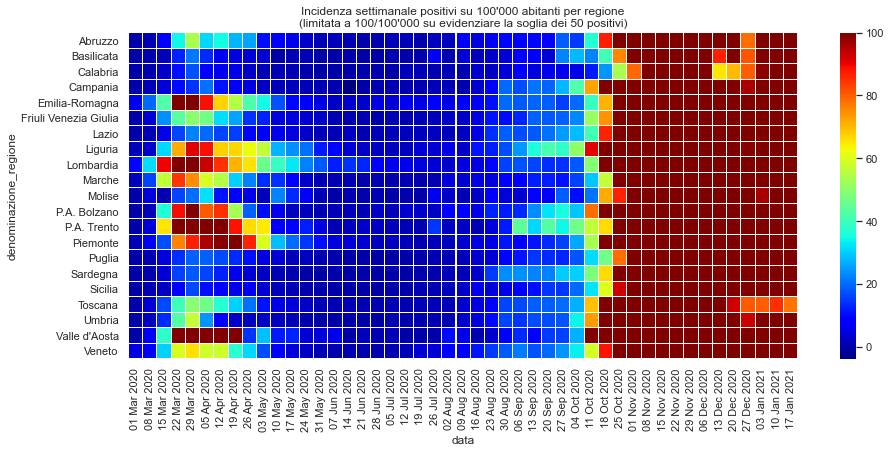

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    fp_w.iloc[:-1,:].T,
    vmax=100,
    cmap='jet', linewidths=.01,
    ax=ax
)
ax.set(
    title="Incidenza settimanale positivi su 100'000 abitanti per regione\n"
    "(limitata a 100/100'000 su evidenziare la soglia dei 50 positivi)"
)
plt.show()

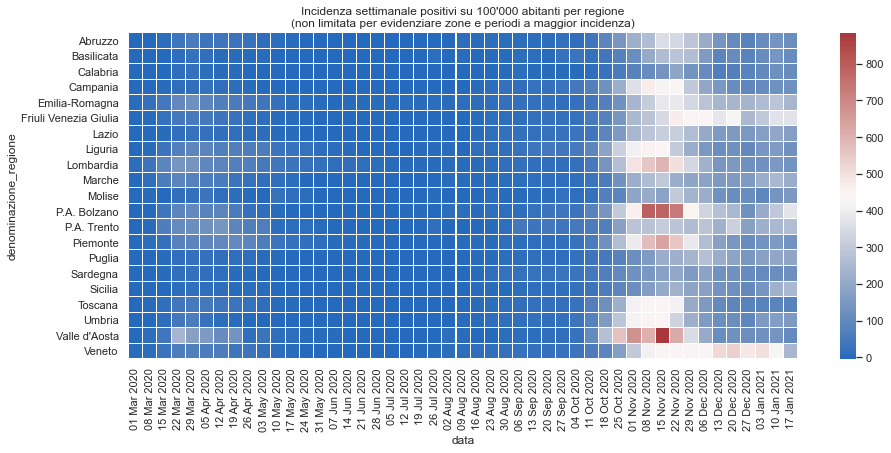

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    fp_w.iloc[:-1,:].T,
    #vmax=100,
    cmap='vlag', linewidths=.01,
    ax=ax
)
ax.set(
    title="Incidenza settimanale positivi su 100'000 abitanti per regione\n"
    "(non limitata per evidenziare zone e periodi a maggior incidenza)"
)
plt.show()

In [11]:
dfs = {}

for regione in it.denominazione_regione.unique():
    _df = it[it.denominazione_regione==regione].copy(deep=True)
    _df['nuovi_deceduti'] = _df.deceduti.diff()
    _df['nuovi_guariti'] = _df.dimessi_guariti.diff()
    dfs.update({regione: _df})

In [12]:
dfW = None
for regione in dfs:
    _dfW = dfs[regione].resample('W').sum()
    _dfW['regione'] = regione
    _dfW['incidenza_positivi'] = _dfW.nuovi_positivi / pop_reg[pop_reg.Territorio==regione].Value.values[0] * 100000
    _dfW['incidenza_guariti'] = _dfW.nuovi_guariti / pop_reg[pop_reg.Territorio==regione].Value.values[0] * 100000
    _dfW['incidenza_deceduti'] = _dfW.nuovi_deceduti / pop_reg[pop_reg.Territorio==regione].Value.values[0] * 100000
    if dfW is None:
        dfW = _dfW
    else:
        dfW = dfW.append(_dfW)

# Incidenza Positivi

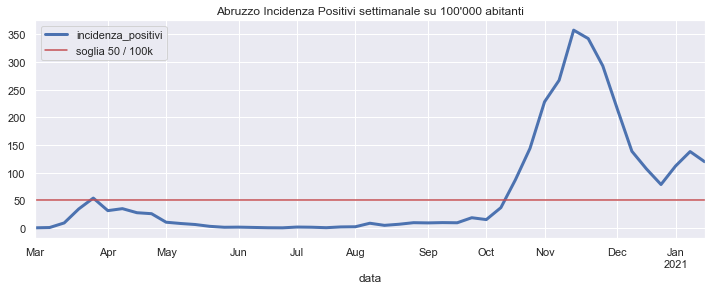

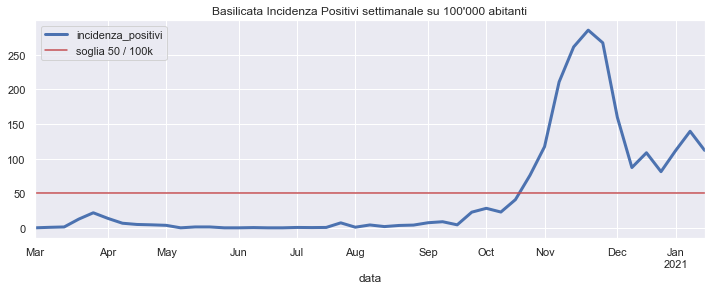

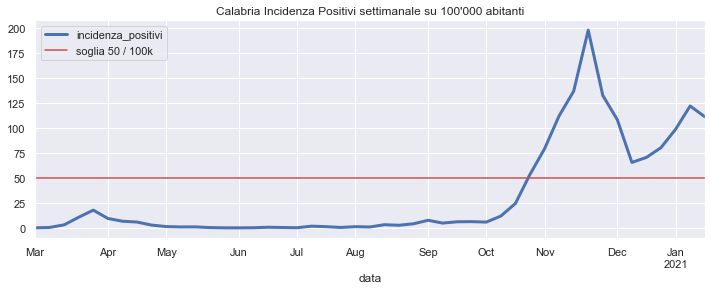

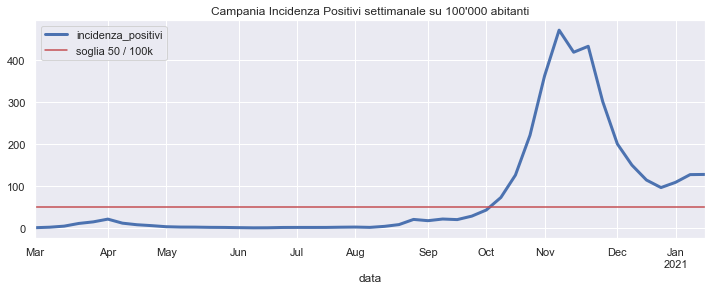

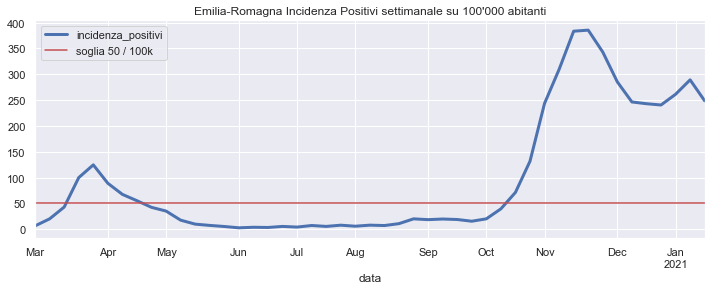

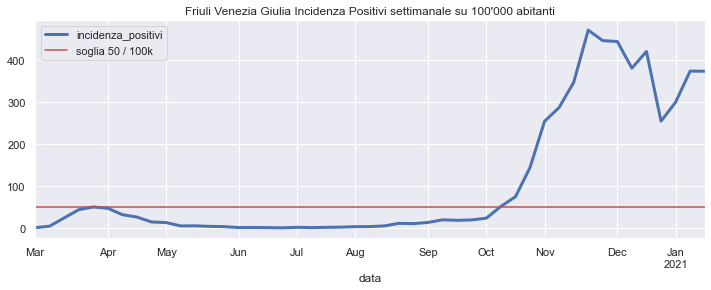

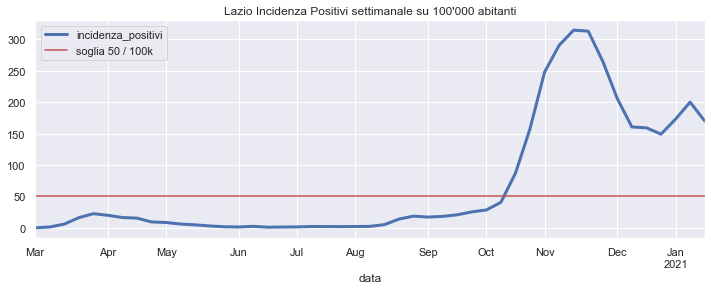

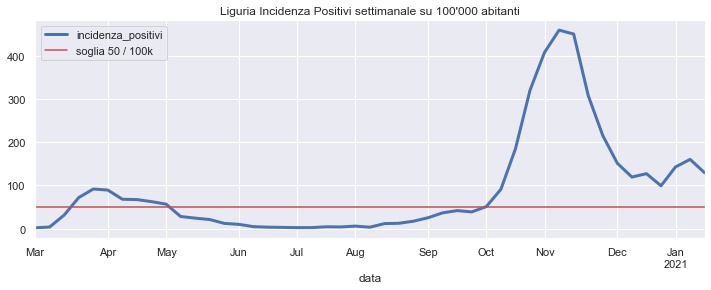

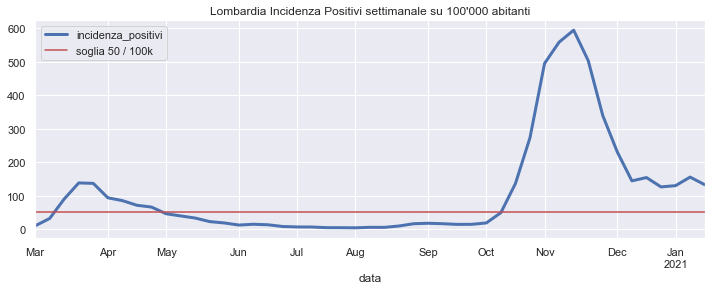

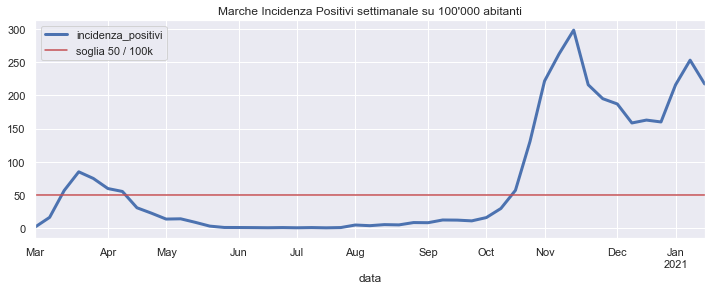

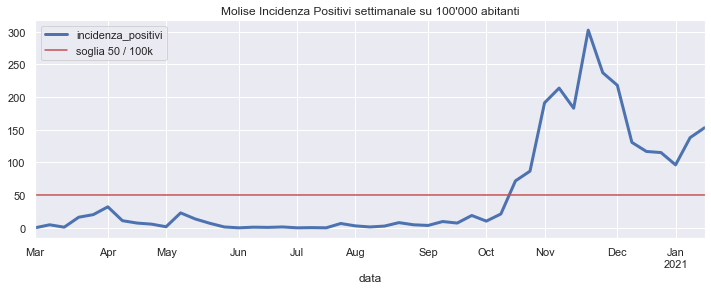

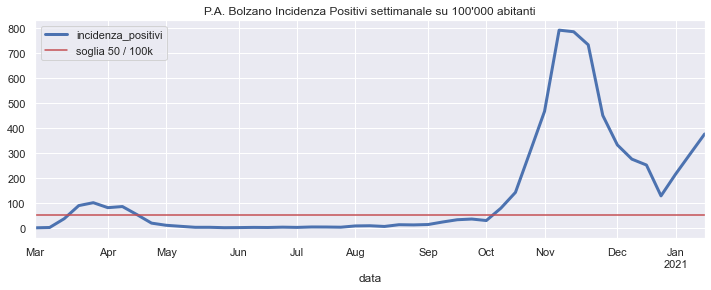

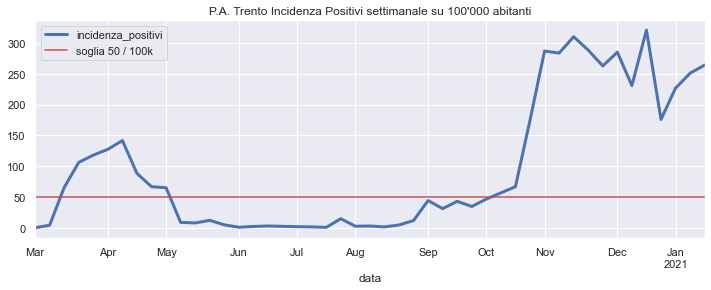

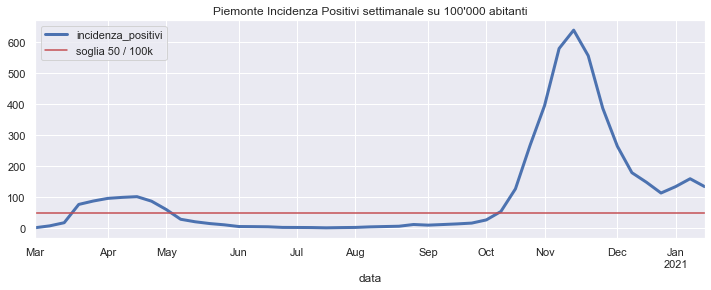

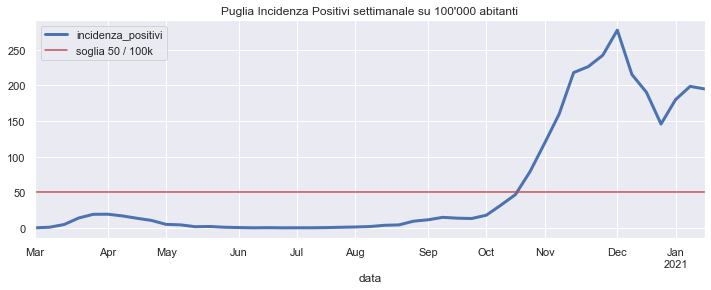

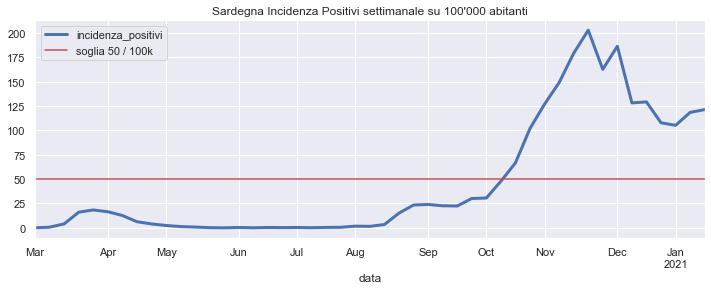

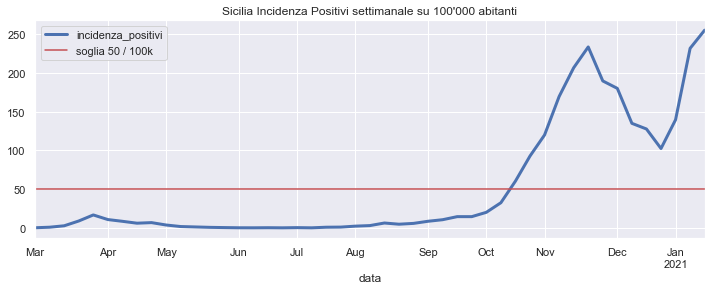

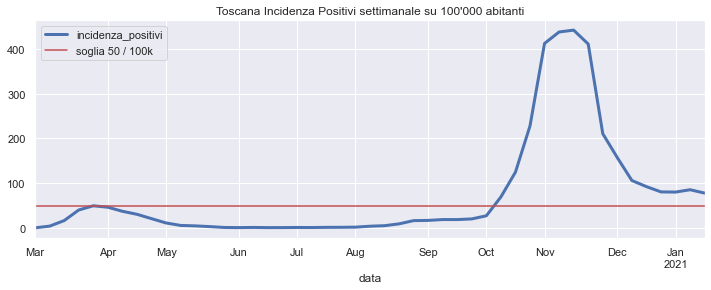

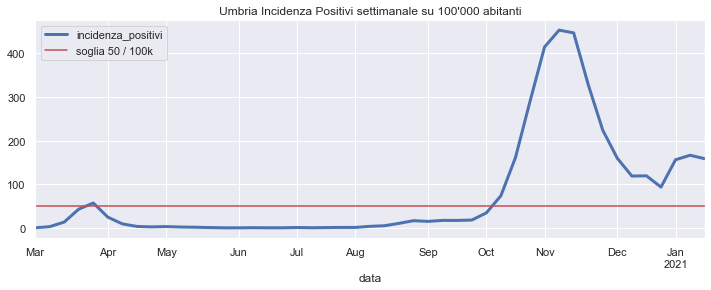

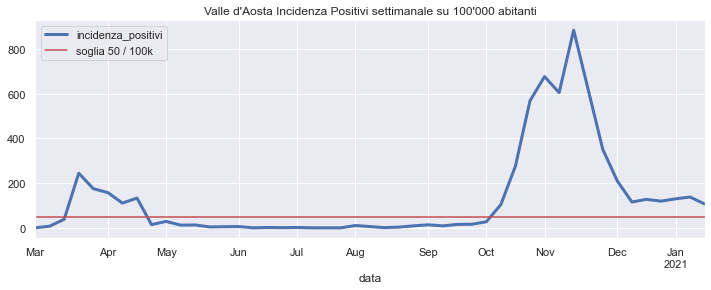

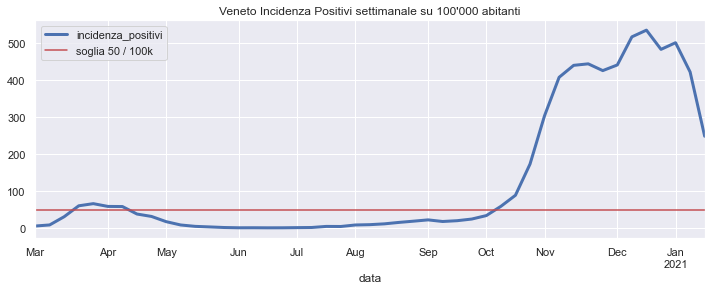

# Incidenza Deceduti

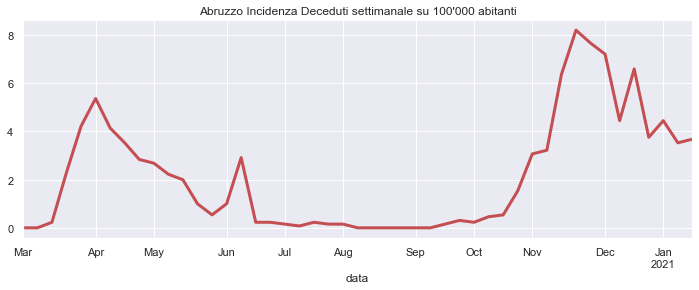

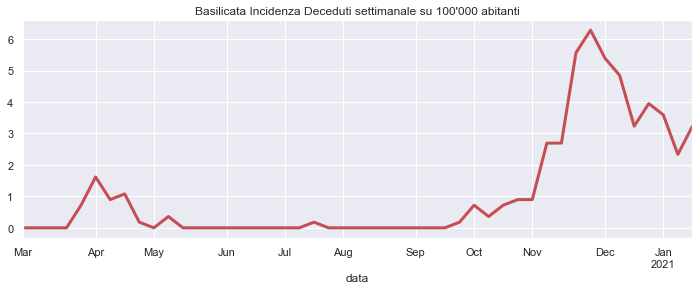

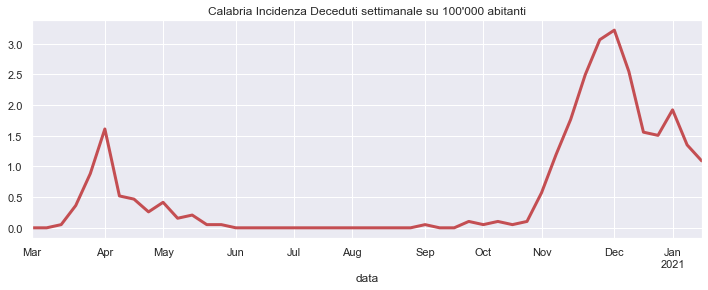

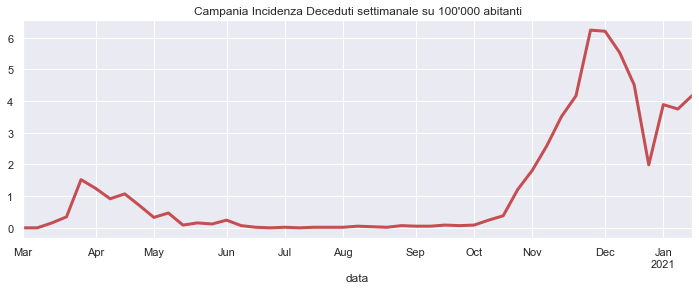

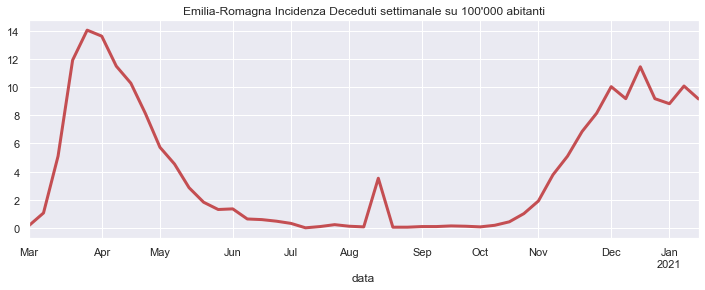

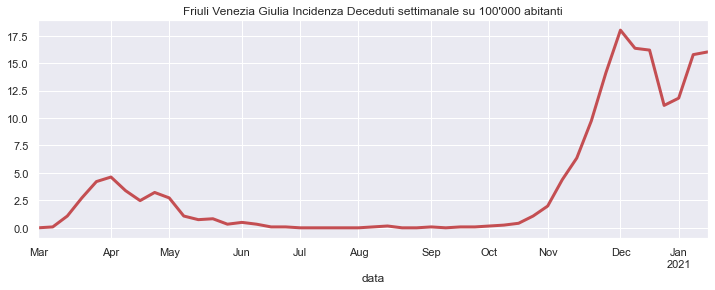

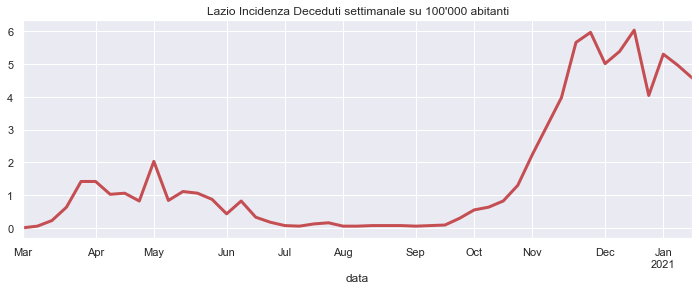

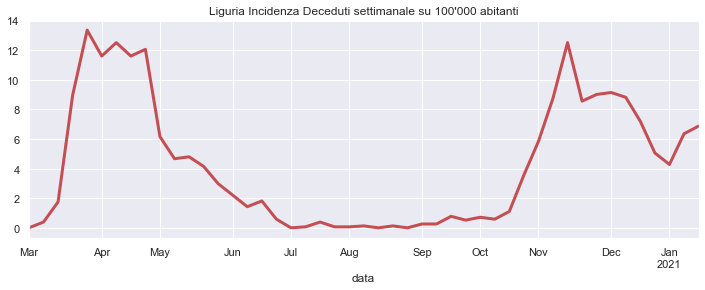

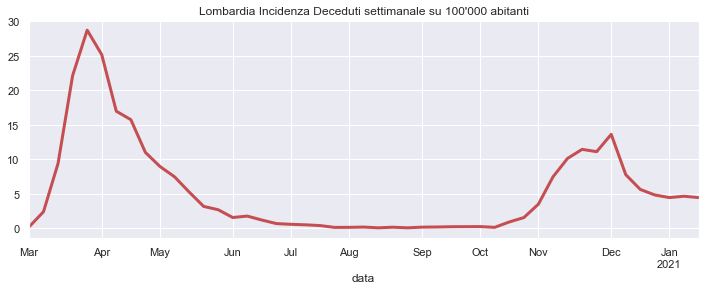

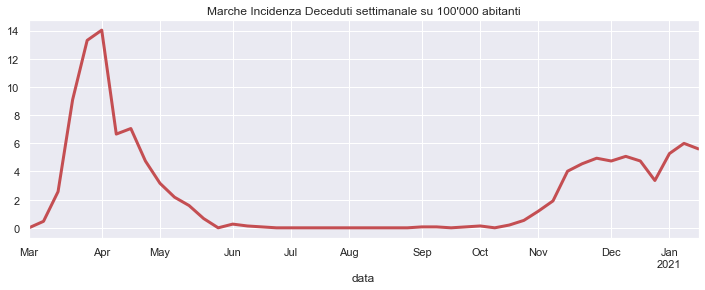

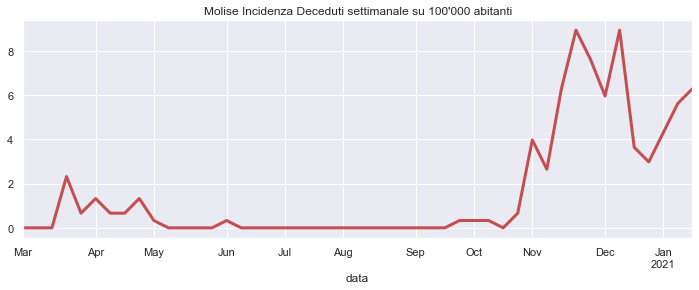

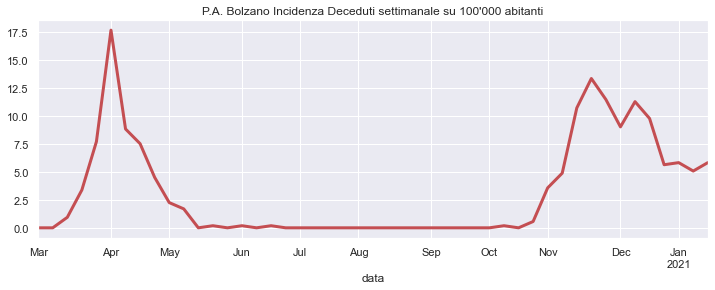

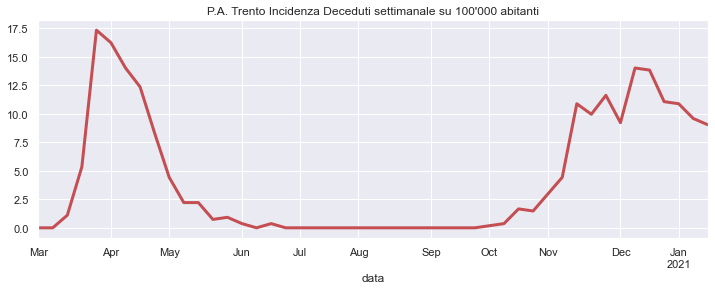

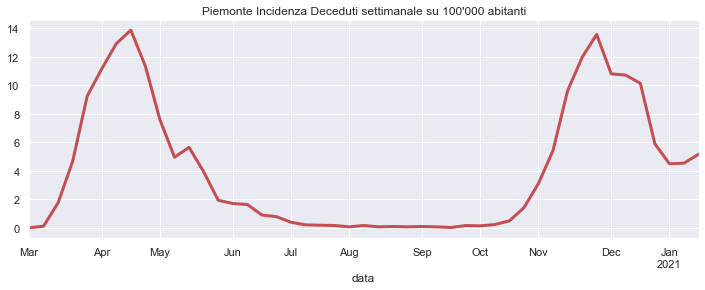

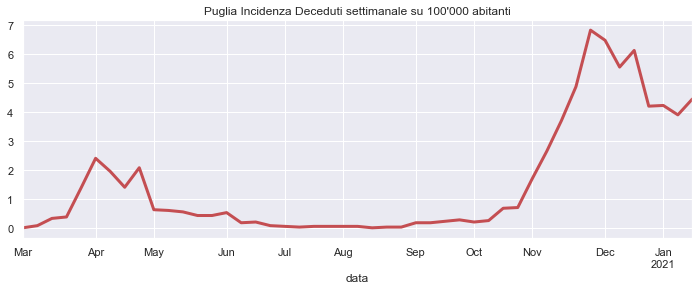

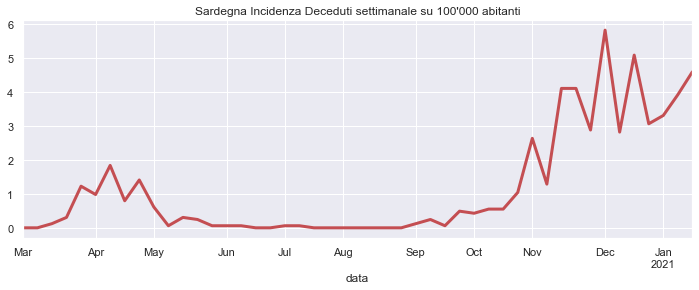

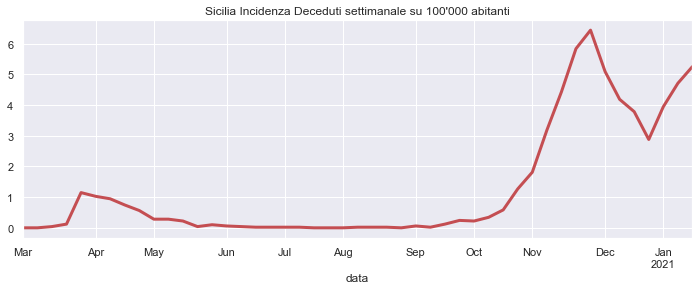

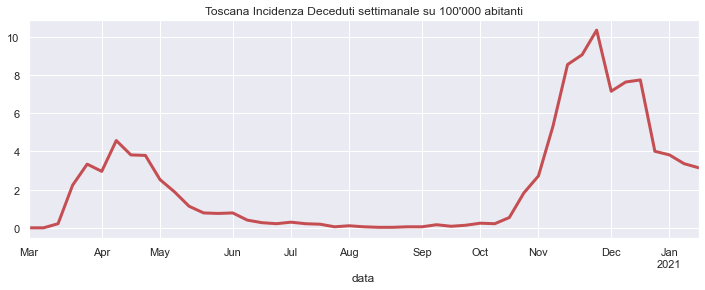

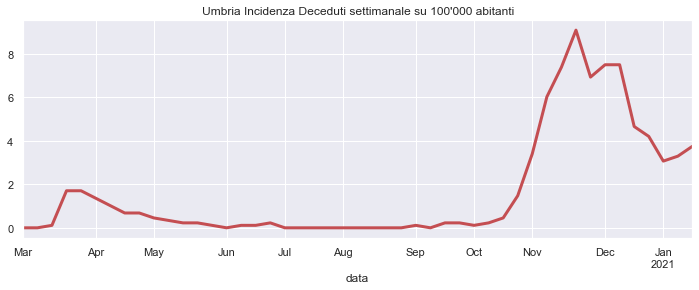

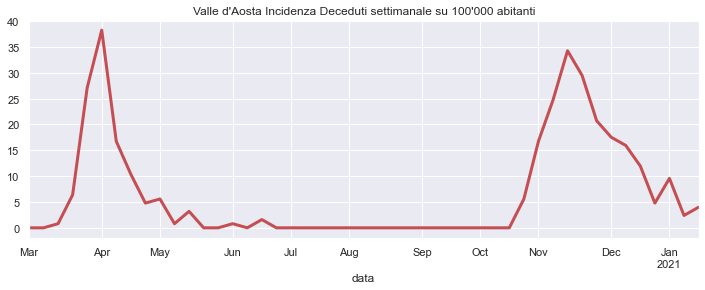

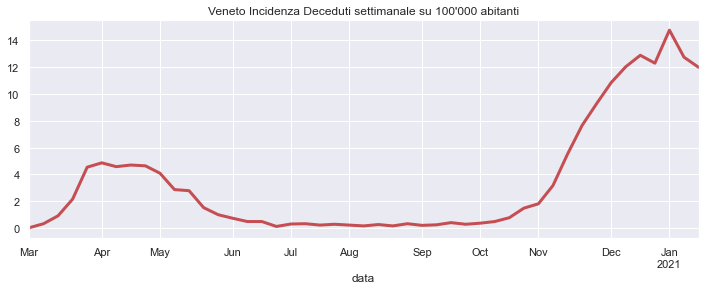

# Incidenza Guariti

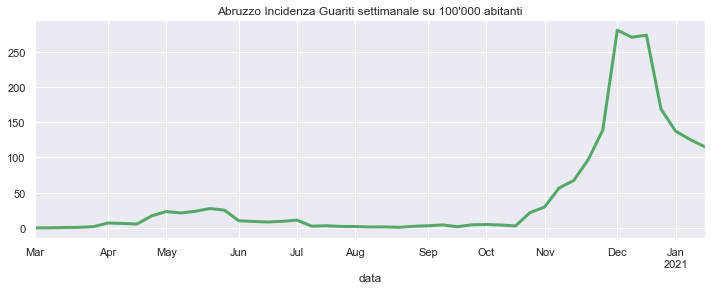

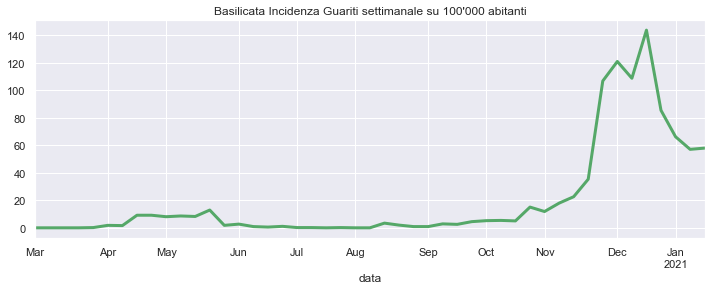

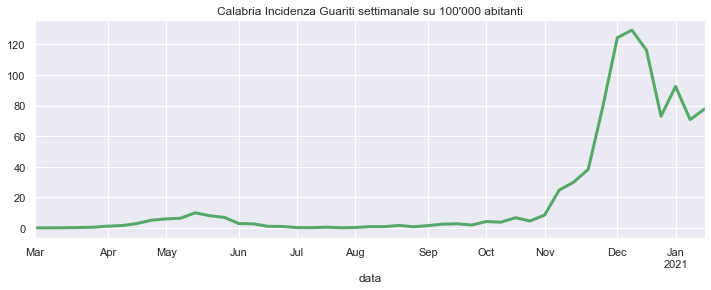

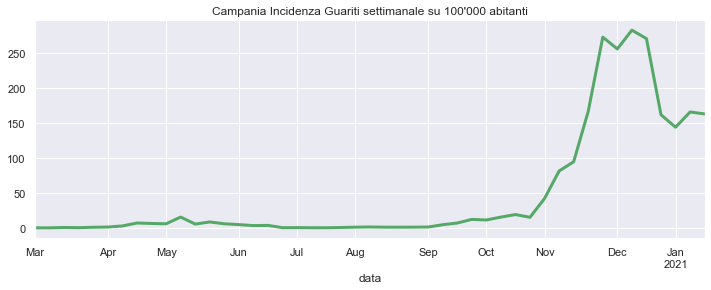

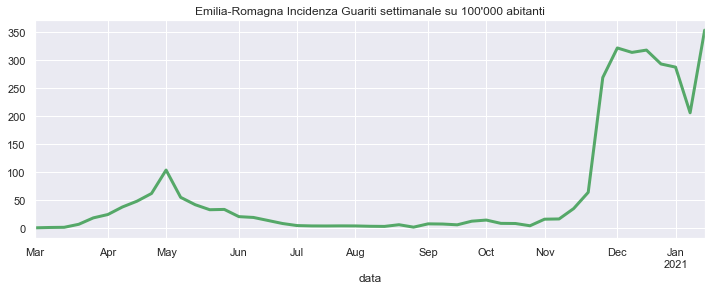

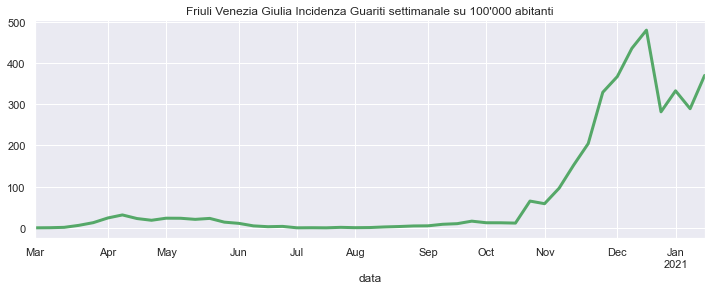

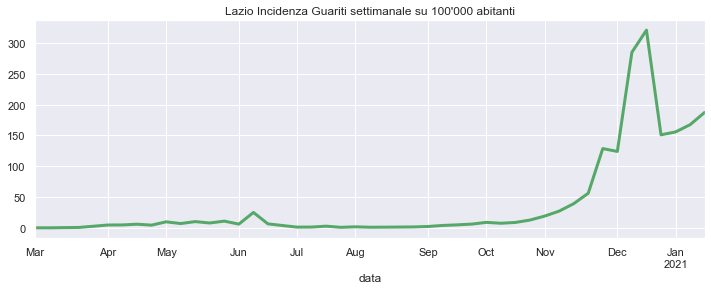

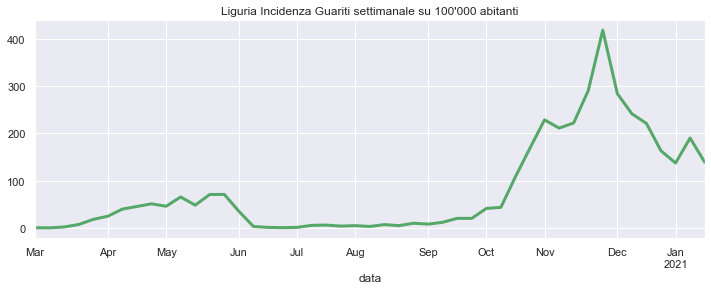

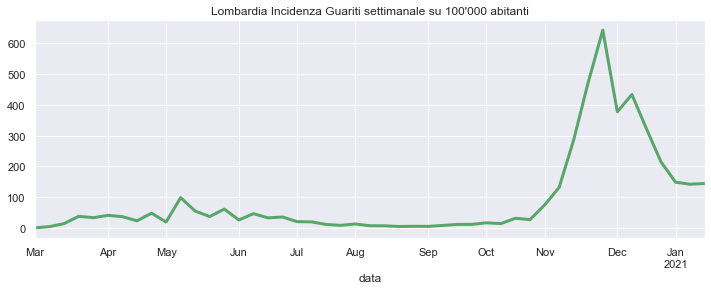

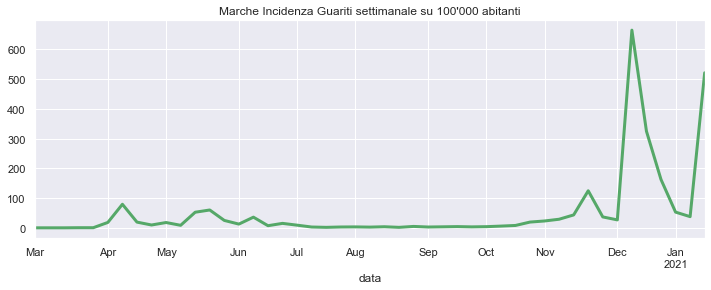

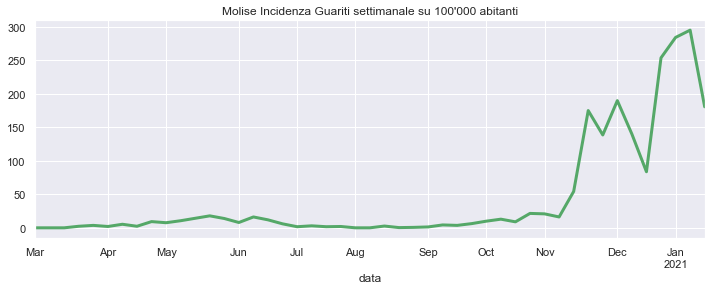

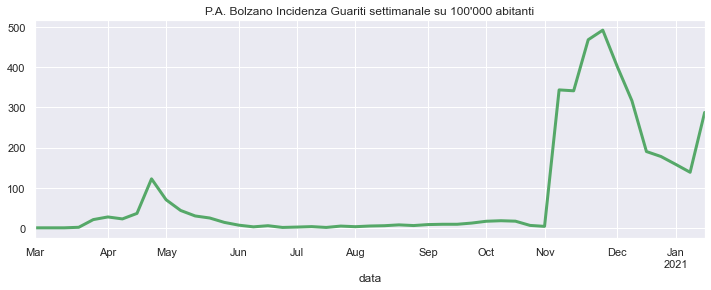

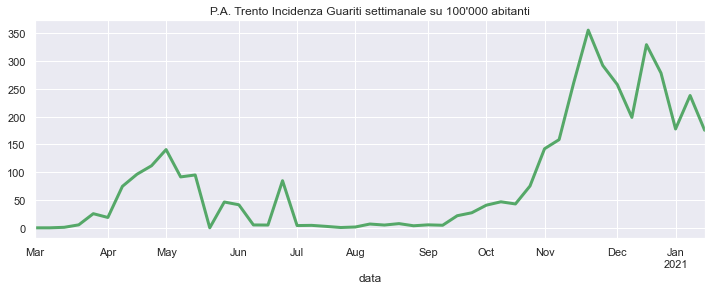

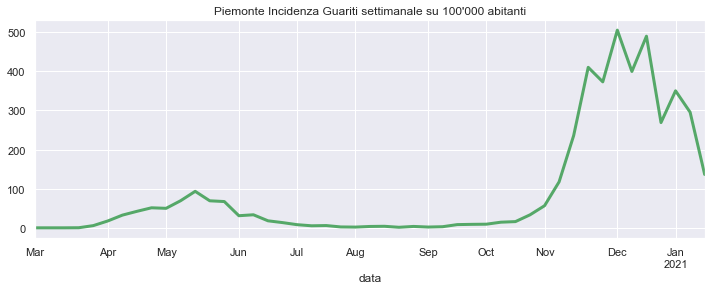

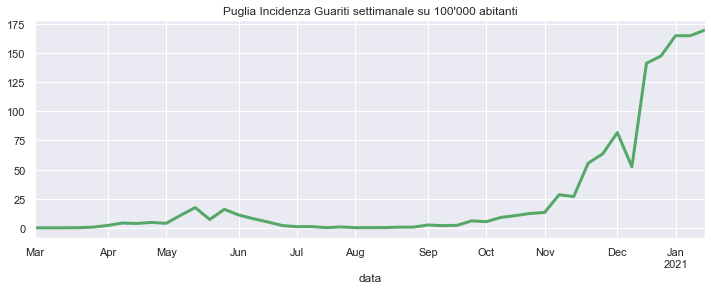

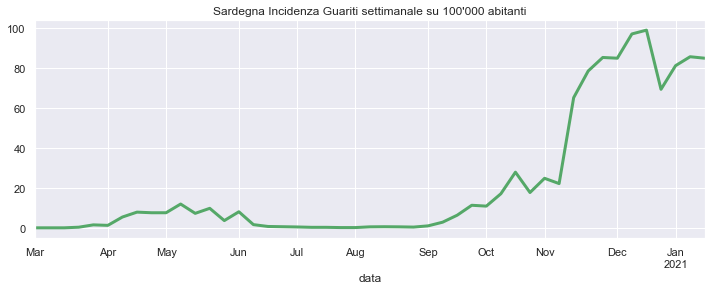

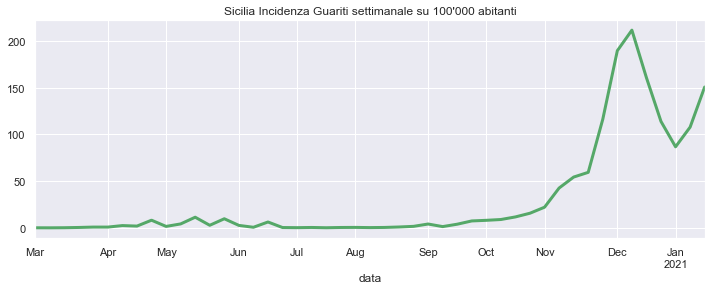

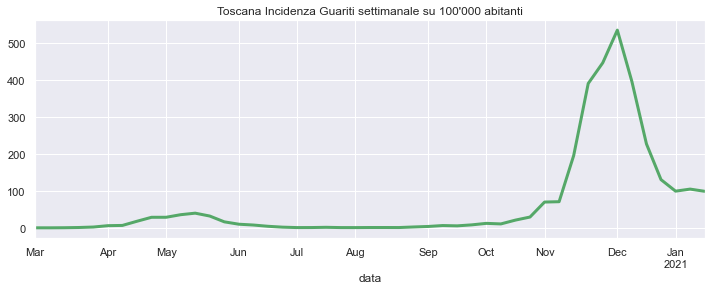

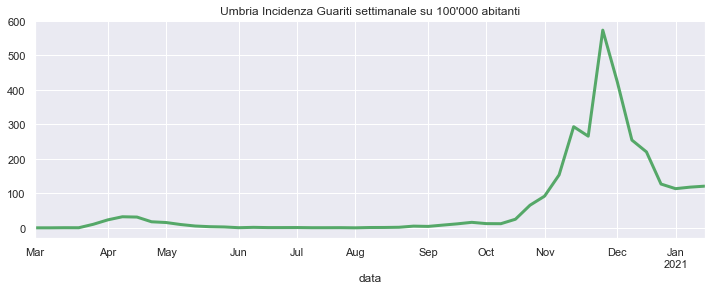

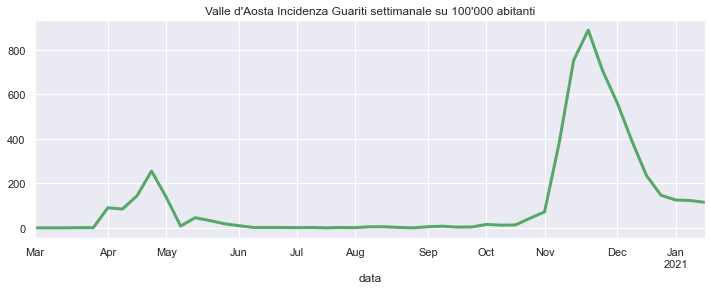

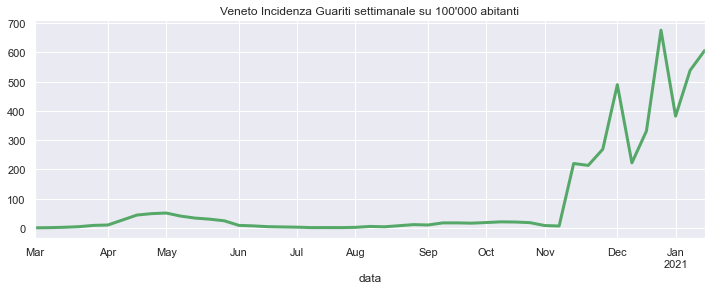

In [13]:
colors = ['b', 'r', 'g']

for i, y in enumerate(['incidenza_positivi', 'incidenza_deceduti', 'incidenza_guariti']):
    title = y.replace('_', ' ').title()
    display(Markdown(f"# {title}"))
    for regione in dfW.regione.unique():
        regW = dfW[dfW.regione==regione][:-1]
        regW.loc[regW[y]<0, y] = 0
        ax = regW.plot(
            y=y,
            lw=3, color=colors[i],
            title=f"{regione} {title} settimanale su 100'000 abitanti",
            legend=False,
            figsize=(12, 4)
        )
        if y == 'incidenza_positivi':
            ax.axhline(50, color='r', label='soglia 50 / 100k')
            ax.legend(loc='upper left')
        plt.show()